In [73]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import eigen_analysis

cols = eigen_analysis.LINUX_COLS
time_unit = eigen_analysis.TIME_CONVERSION_khz
joules_unit = eigen_analysis.JOULE_CONVERSION

In [4]:
# get all itrs explored for some (dvfs, qps) pair
def list_itrs(rdtsc_dirname):
    itrs = []
    for file in os.listdir(rdtsc_dirname):
        tags = file.split('_')
        itr = tags[1]
        itrs.append(itr)
    itrs = list(set(itrs))
    return itrs

In [5]:
global itrs

In [6]:
def print_err_log(dvfs, qps, itr, rapl='135', run='0', err_dir = 'err_logs/'):
    err_filename = 'err_log_' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    if os.path.exists(err_dir + err_filename):
        err_file = open(err_dir + err_filename, 'r')
        print(err_file.read())
    else:
        print('EMPTY ERROR LOG')

In [7]:
def handle_neg_diffs(df_diffs, df, core, err_file):
    
    tmp = df_diffs.copy()

    # isolating rows with negative diffs
    tmp_neg = tmp[(tmp['joules_diff'] < 0) | (tmp['instructions_diff'] < 0) | (tmp['cycles_diff'] < 0) \
                   | (tmp['ref_cycles_diff'] < 0) | (tmp['llc_miss_diff'] < 0) | (tmp['timestamp_diff'] < 0)]

    # re-computing diffs if possible; else dropping rows
    for i,j in tmp_neg.iterrows():
        prev = df.shift(1).loc[i]
        cur = df.loc[i]
        # TODO note that we are only handling case of RAPL-energy-status register overflow
        if (tmp.loc[i]['joules_diff'] < 0) & (tmp.loc[i]['timestamp_diff'] >= 0.001):
            err_file.write('CORE ' + str(core) + '  ---  JOULES COUNTER OVERFLOW AT LOG ENTRY DIFF #' + str(i) + '\n')
            tmp.loc[i, ['joules_diff']] = (2**32 - 1) * joules_unit - prev['joules'] + cur['joules'] 
        else:
            err_file.write('CORE ' + str(core) + '  ---  UNEXPLAINED NEGATIVE VALS AT LOG ENTRY DIFF # ' + str(i) + '\n')
            cols = ''
            prevs = ''
            currs = ''
            for col in list(df.columns):
                cols += col + '  '
                prevs += str(prev[col]) + '  '
                currs += str(cur[col]) + '  '
            err_file.write('          ' + cols + '\n')
            err_file.write('         log[' + str(i-1) + ']: ' + prevs + '\n')
            err_file.write('         log[' + str(i) + ']: ' + currs + '\n')
            tmp = tmp.drop(i, axis=0)

    return tmp

### Correlation matrices and eigenvals:

In [8]:
def per_core_corr(dvfs, qps, itr, rapl='135', run='0'):

    counters_corr_dict = {}
    non_counters_corr_dict = {}

    # here are all the log files for this dvfs & qps
    logs_dir = qps + '_qps/linux_mcd_dmesg_' + run + '_' + dvfs + '_' + rapl + '_' + qps + '/'
    # here are all the time-management files for this dvfs & qps
    rdtsc_dir = qps + '_qps/linux_mcd_rdtsc_' + run + '_' + dvfs + '_' + rapl + '_' + qps +'/'
    rdtsc_file = rdtsc_dir + 'linux.mcd.rdtsc.' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    start, end = eigen_analysis.get_rdtsc(rdtsc_file)

    # initializing error log file
    err_dir = 'err_logs/'
    err_filename = 'err_log_' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    err_file = open(err_dir + err_filename, 'w')

    # TODO remove fixed core-id range
    for c in range(0,16):
        file = logs_dir + 'linux.mcd.dmesg.' + run + '_' + str(c) + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
        df = pd.read_csv(file, sep = ' ', names = cols, index_col='i')
        df = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]
        df['timestamp'] = df['timestamp'] - df['timestamp'].min()
        df['timestamp'] = df['timestamp'] * time_unit
        df['joules'] = df['joules'] * joules_unit
        counters_df = df[['joules', 'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'timestamp']].copy()
        counters_df = counters_df[(counters_df['joules'] > 0) & (counters_df['instructions'] > 0) \
                                            & (counters_df['cycles'] > 0) & (counters_df['ref_cycles'] > 0) \
                                            & (counters_df['llc_miss'] > 0)]
        # computing diffs of counter readings
        df_diffs = counters_df.diff().dropna().copy()
        df_diffs.columns = [f'{c}_diff' for c in df_diffs.columns]
        df_diffs = handle_neg_diffs(df_diffs, counters_df, c, err_file)
        df_corr = df_diffs.drop(['timestamp_diff', 'joules_diff'], axis = 1).corr()
        counters_corr_dict[str(c)] = df_corr

        non_counters_df = df[['rx_bytes', 'rx_desc', 'tx_bytes', 'tx_desc']].copy()
        df_corr = non_counters_df.corr()
        non_counters_corr_dict[str(c)] = df_corr
        
    return counters_corr_dict, non_counters_corr_dict

In [26]:
def merged_core_corr(dvfs, qps, itr, rapl='135', run='0'):
    merged_counters_dir = qps + '_' + dvfs + '_counters_merged/'
    merged_non_counters_dir = qps + '_' + dvfs + '_non_counters_merged/'
    counters_df = pd.read_csv(merged_counters_dir + dvfs + '_' + qps + '_' + itr + '_counters_merged', index_col=0)
    non_counters_df = pd.read_csv(merged_non_counters_dir + dvfs + '_' + qps + '_' + itr + '_non_counters_merged', index_col=0)
    counters_corr = counters_df.drop(['timestamp', 'joules_diff'], axis = 1).corr()
    non_counters_corr = non_counters_df.drop(['timestamp'], axis = 1).corr()
    
    return counters_corr, non_counters_corr

In [27]:
counters_corr, non_counters_corr = merged_core_corr('0xd00', '400k', '250')

In [28]:
counters_corr

,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
instructions_diff,1.000000,0.699121,0.697417,0.246218
cycles_diff,0.699121,1.000000,0.999980,0.814058
ref_cycles_diff,0.697417,0.999980,1.000000,0.816018
llc_miss_diff,0.246218,0.814058,0.816018,1.000000


In [29]:
non_counters_corr

,rx_bytes,rx_desc,tx_bytes,tx_desc
rx_bytes,1.000000,0.706453,0.009870,0.008841
rx_desc,0.706453,1.000000,0.028984,0.022868
tx_bytes,0.009870,0.028984,1.000000,0.602975
tx_desc,0.008841,0.022868,0.602975,1.000000


In [136]:
from numpy.linalg import eig, eigvalsh

def get_eig_vals(counters_corr_dict, non_counters_corr_dict, merged_counters_corr, merged_non_counters_corr):
    all_core_eigvals = {}
    
    for c in range(0,16):
        counter_vals, vecs = eig(counters_corr_dict[str(c)])
        for i in range(0, len(counter_vals)):
            counter_vals[i] = counter_vals[i] / counter_vals[0]
        non_counter_vals, vecs = eig(non_counters_corr_dict[str(c)])
        for i in range(0, len(non_counter_vals)):
            non_counter_vals[i] = non_counter_vals[i] / non_counter_vals[0]
        all_core_eigvals[str(c)] = np.concatenate([np.log(counter_vals) , np.log(non_counter_vals)])

    merged_counter_vals, merged_vecs = eig(merged_counters_corr)
    for i in range(0, len(merged_counter_vals)):
        merged_counter_vals[i] = merged_counter_vals[i] / merged_counter_vals[0]
    merged_non_counter_vals, merged_vecs = eig(merged_non_counters_corr)
    for i in range(0, len(merged_non_counter_vals)):
        merged_non_counter_vals[i] = merged_non_counter_vals[i] / merged_non_counter_vals[0]
    all_core_eigvals['merged'] = np.concatenate([np.log(merged_counter_vals), np.log(merged_non_counter_vals)])
    
    return all_core_eigvals

In [126]:
def plot_eig_vals(eig_dict, dvfs, qps, itr):
    plt.figure(figsize=(10,6))
    num_eig = len(list(eig_dict.values())[0])
    eig_list = [str(i) for i in range(0, num_eig)]
    for core in eig_dict.keys():
        vals = eig_dict[core]
        #print(vals)
        plt.plot(eig_list, vals, 'p')
    plt.plot(eig_list, eig_dict['merged'], 'x')    
    plt.xlabel('eig_id')
    plt.ylabel('eig_val')
    plt.title(f'Eigenvals for ITR-DELAY {itr} DVFS {dvfs} QPS {qps}')
    plt.show()
    plt.savefig('plots/eigvals_'+ dvfs + '_' + qps + '_' + itr)

In [137]:
dvfs = '0xd00'
qps = '400k'
counters_corr_dict, non_counters_corr_dict = per_core_corr(dvfs, qps, '400')
merged_counters_corr, merged_non_counters_corr = merged_core_corr(dvfs, qps, '400')

In [128]:
counters_corr_dict['15']

,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
instructions_diff,1.000000,0.913362,0.913680,0.611472
cycles_diff,0.913362,1.000000,0.999977,0.776957
ref_cycles_diff,0.913680,0.999977,1.000000,0.776711
llc_miss_diff,0.611472,0.776957,0.776711,1.000000


In [129]:
non_counters_corr_dict['0']

,rx_bytes,rx_desc,tx_bytes,tx_desc
rx_bytes,1.000000,0.696395,0.004997,-0.001382
rx_desc,0.696395,1.000000,0.022789,0.013494
tx_bytes,0.004997,0.022789,1.000000,0.589583
tx_desc,-0.001382,0.013494,0.589583,1.000000


In [130]:
merged_counters_corr

,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
instructions_diff,1.000000,0.895295,0.895636,0.618486
cycles_diff,0.895295,1.000000,0.999963,0.776674
ref_cycles_diff,0.895636,0.999963,1.000000,0.776487
llc_miss_diff,0.618486,0.776674,0.776487,1.000000


In [131]:
merged_non_counters_corr

,rx_bytes,rx_desc,tx_bytes,tx_desc
rx_bytes,1.000000,0.705101,0.017274,0.021899
rx_desc,0.705101,1.000000,0.042964,0.044018
tx_bytes,0.017274,0.042964,1.000000,0.628946
tx_desc,0.021899,0.044018,0.628946,1.000000


In [132]:
eig_vals = get_eig_vals(counters_corr_dict, non_counters_corr_dict, merged_counters_corr, merged_non_counters_corr)

In [133]:
eig_vals

{'0': array([1.00000000e+00, 4.43658049e-01, 6.97914811e-02, 5.91195750e-06,
        1.00000000e+00, 1.58618190e+00, 3.03377771e-01, 4.10388961e-01]),
 '1': array([1.00000000e+00, 3.92186663e-01, 9.30910478e-02, 1.83193035e-04,
        1.00000000e+00, 1.61833376e+00, 2.88904588e-01, 3.66403629e-01]),
 '2': array([1.00000000e+00, 4.07080964e-01, 1.19540361e-01, 5.58103669e-06,
        1.00000000e+00, 1.57535391e+00, 2.80845731e-01, 3.65757772e-01]),
 '3': array([1.00000000e+00, 4.35338170e-01, 7.80645442e-02, 1.49696996e-05,
        1.00000000e+00, 1.57952824e+00, 2.97133720e-01, 4.14668333e-01]),
 '4': array([1.00000000e+00, 3.90096788e-01, 7.42018819e-02, 5.37931466e-06,
        1.00000000e+00, 1.58948107e+00, 2.96258696e-01, 3.87287827e-01]),
 '5': array([1.00000000e+00, 4.20166299e-01, 1.27515557e-01, 1.24608913e-05,
        1.00000000e+00, 1.60675952e+00, 2.96033492e-01, 3.62415707e-01]),
 '6': array([1.00000000e+00, 4.34531745e-01, 7.41641235e-02, 4.27525716e-06,
        1.0000000

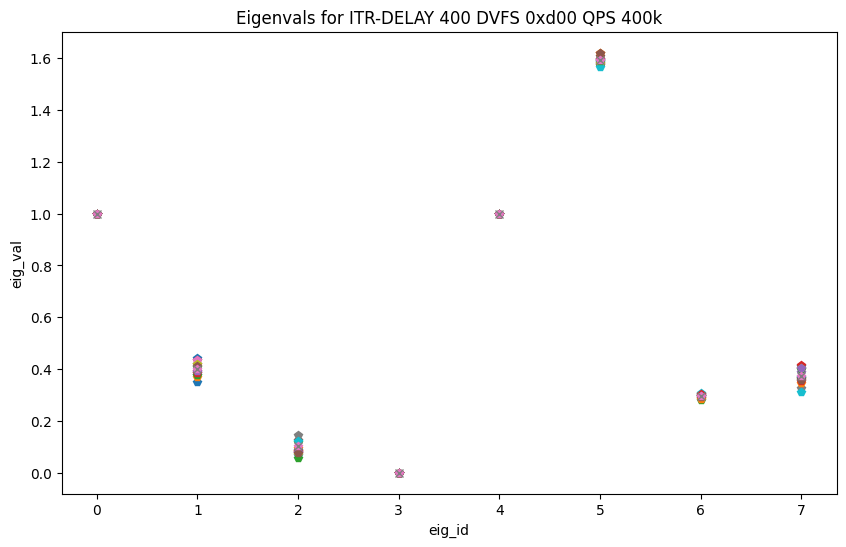

<Figure size 640x480 with 0 Axes>

In [134]:
plot_eig_vals(eig_vals, '0xd00', '400k', '400')

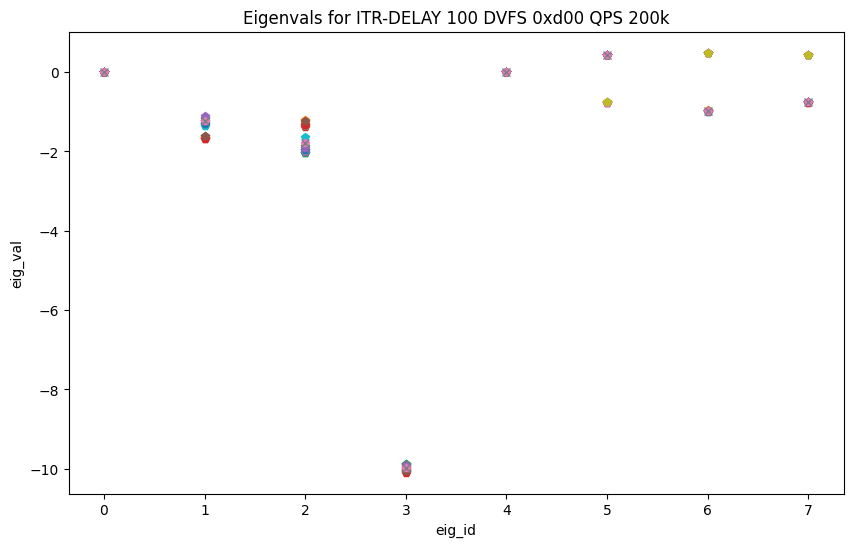

<Figure size 640x480 with 0 Axes>

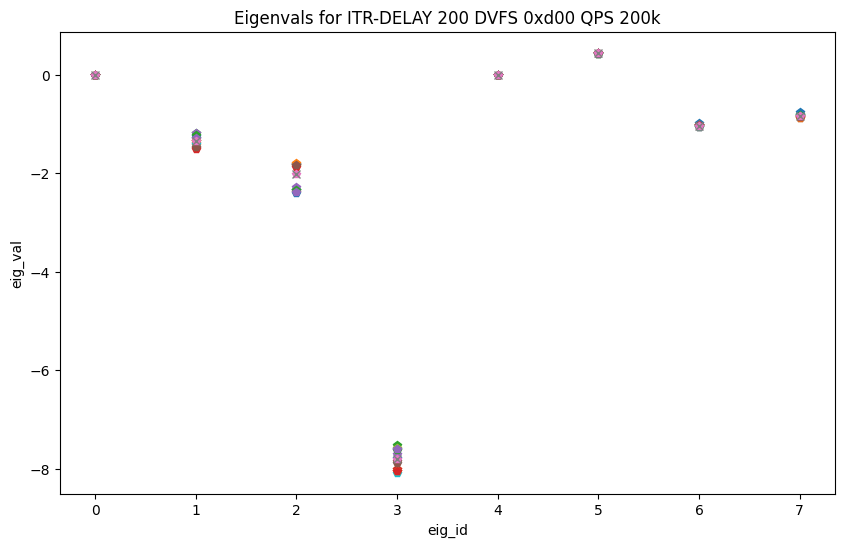

<Figure size 640x480 with 0 Axes>

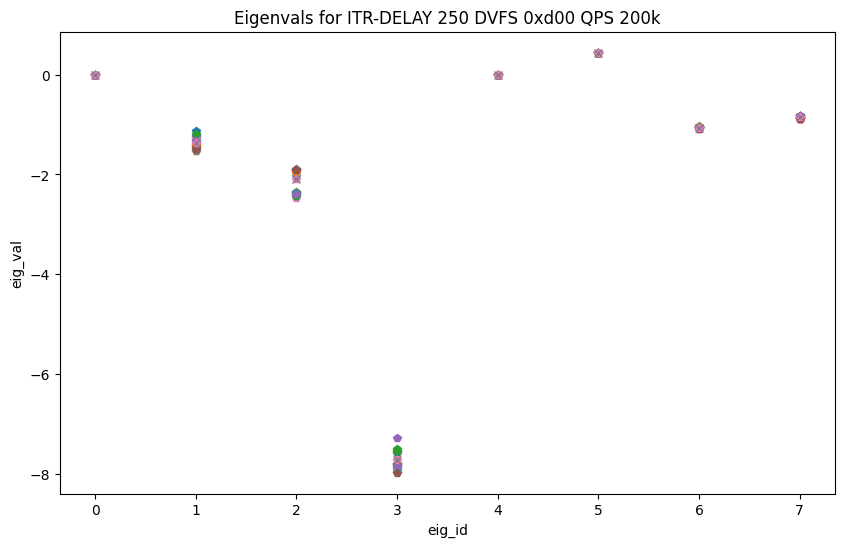

<Figure size 640x480 with 0 Axes>

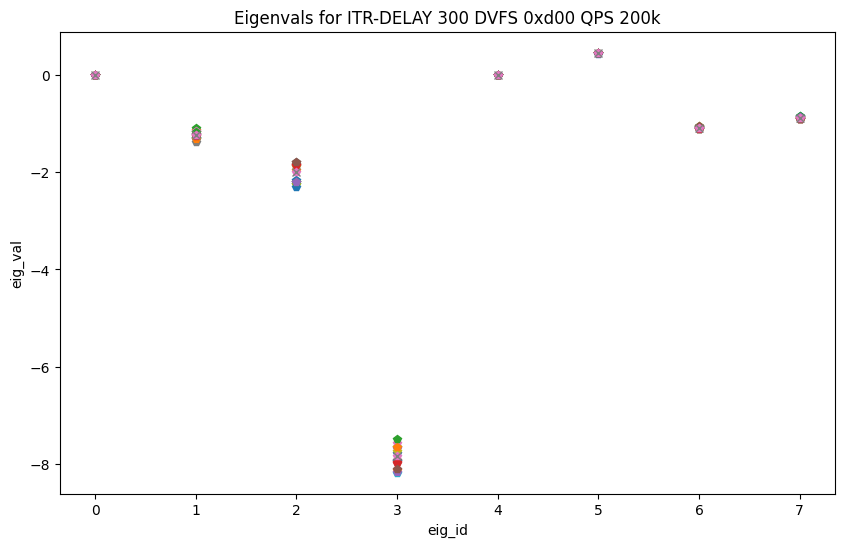

<Figure size 640x480 with 0 Axes>

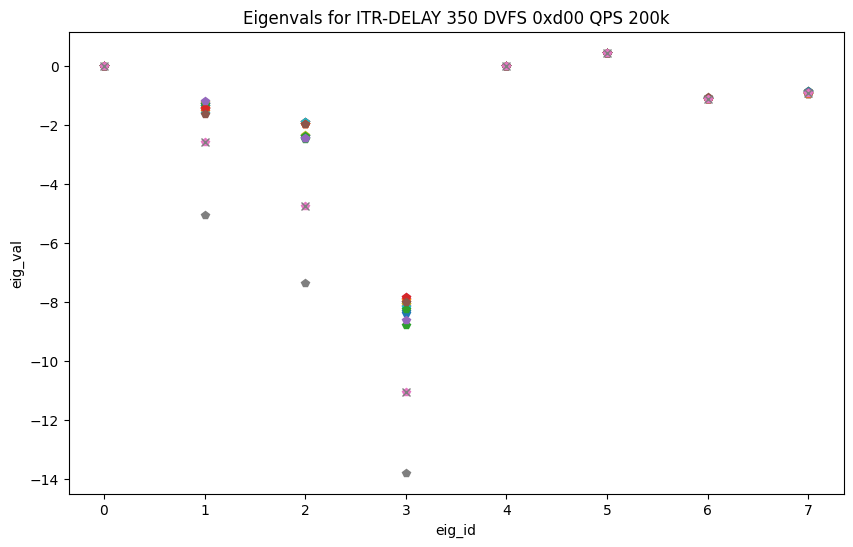

<Figure size 640x480 with 0 Axes>

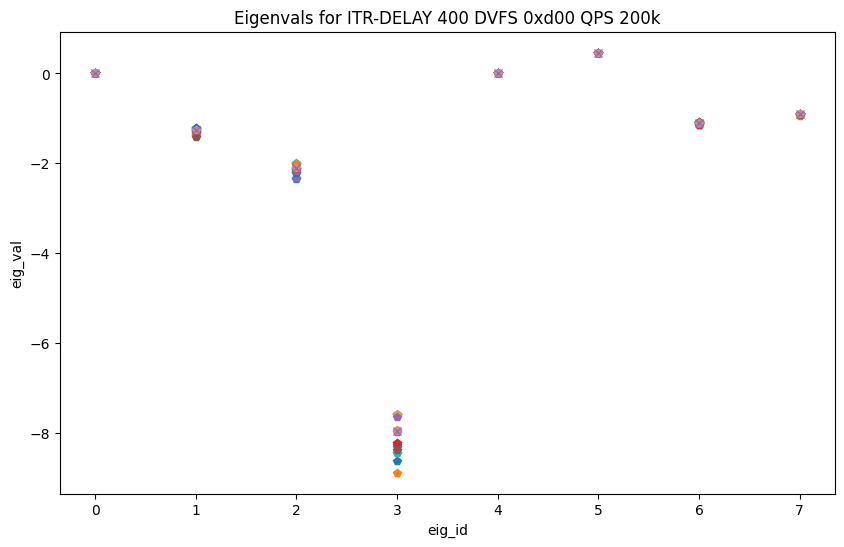

<Figure size 640x480 with 0 Axes>

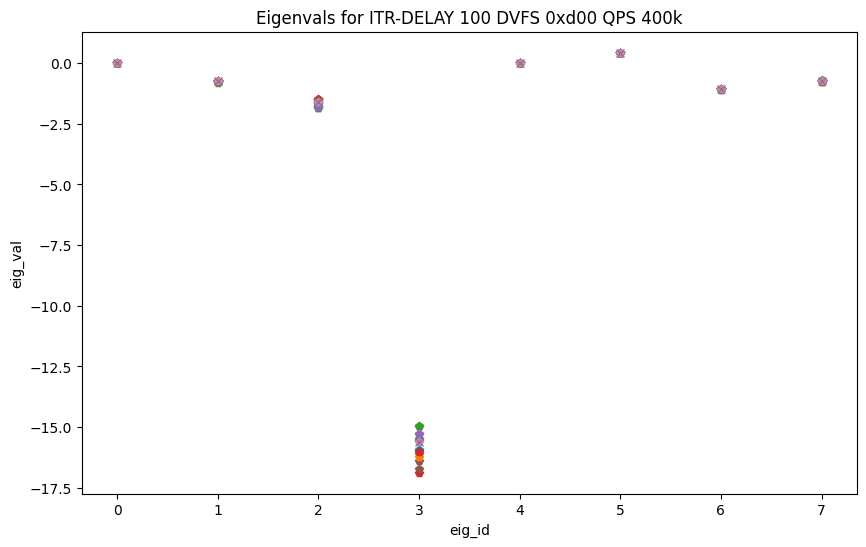

<Figure size 640x480 with 0 Axes>

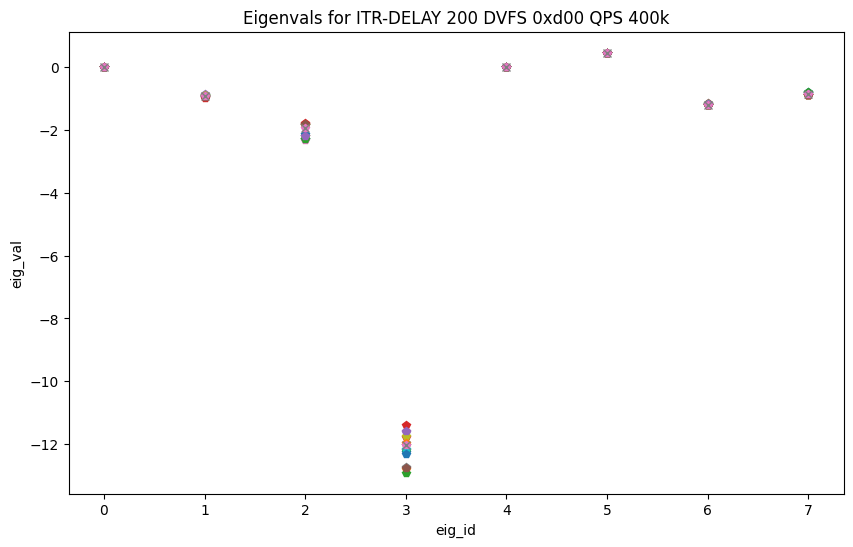

<Figure size 640x480 with 0 Axes>

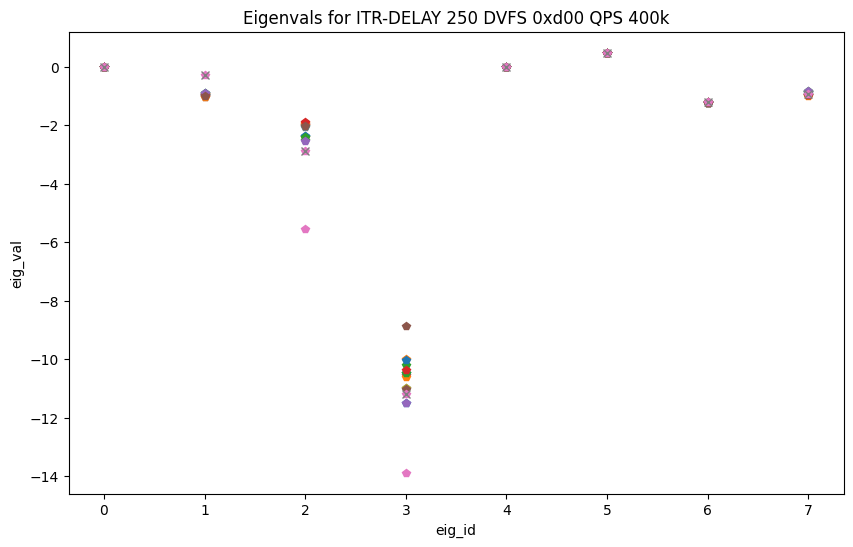

<Figure size 640x480 with 0 Axes>

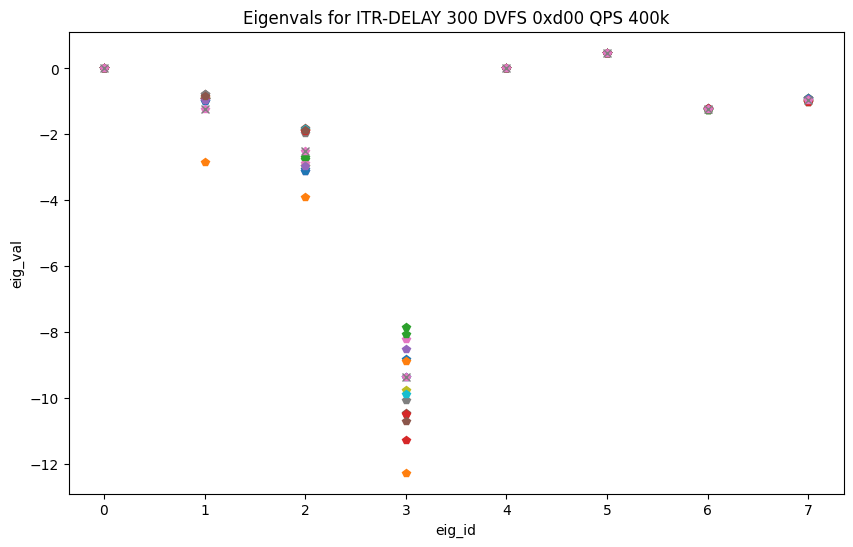

<Figure size 640x480 with 0 Axes>

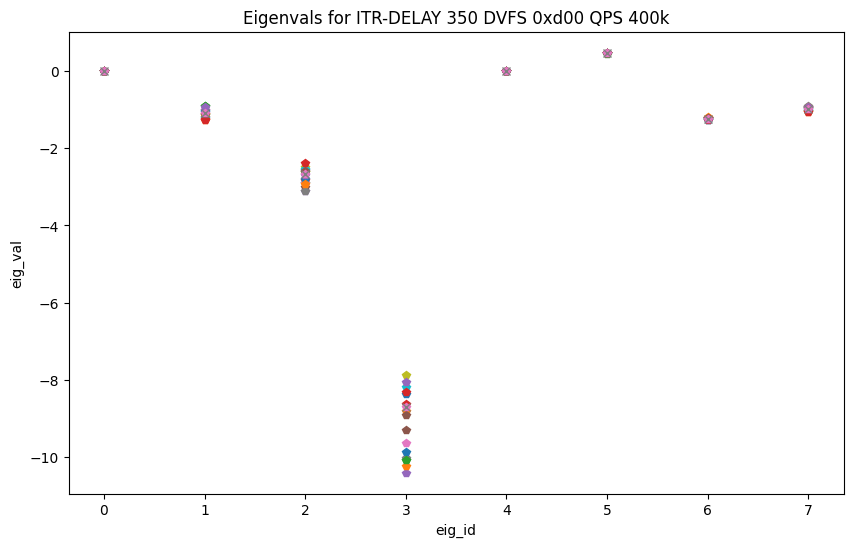

<Figure size 640x480 with 0 Axes>

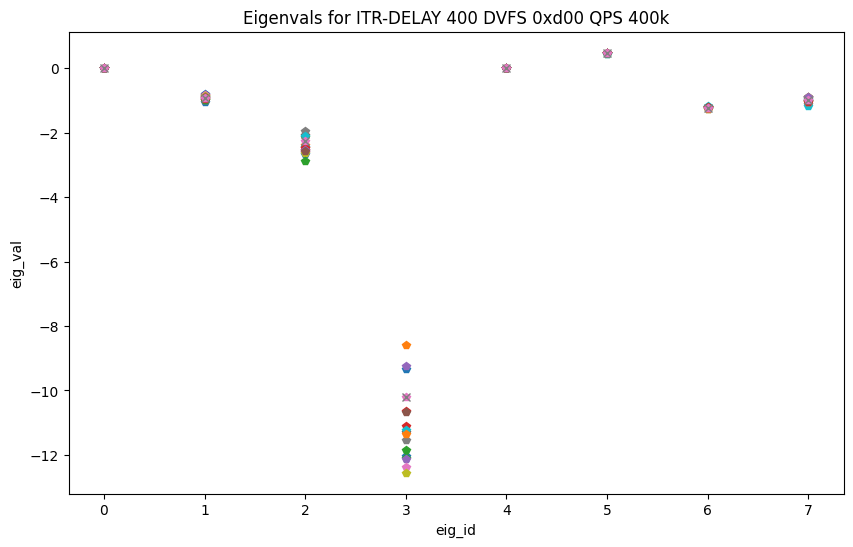

<Figure size 640x480 with 0 Axes>

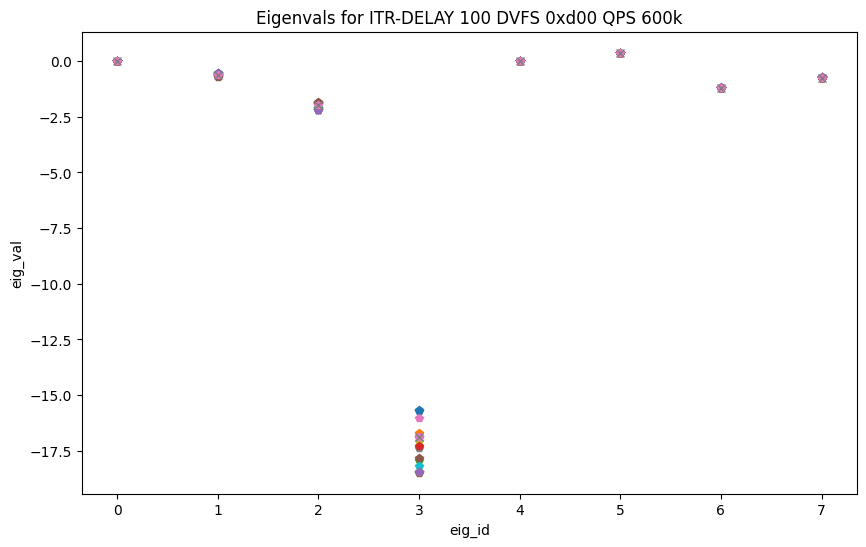

<Figure size 640x480 with 0 Axes>

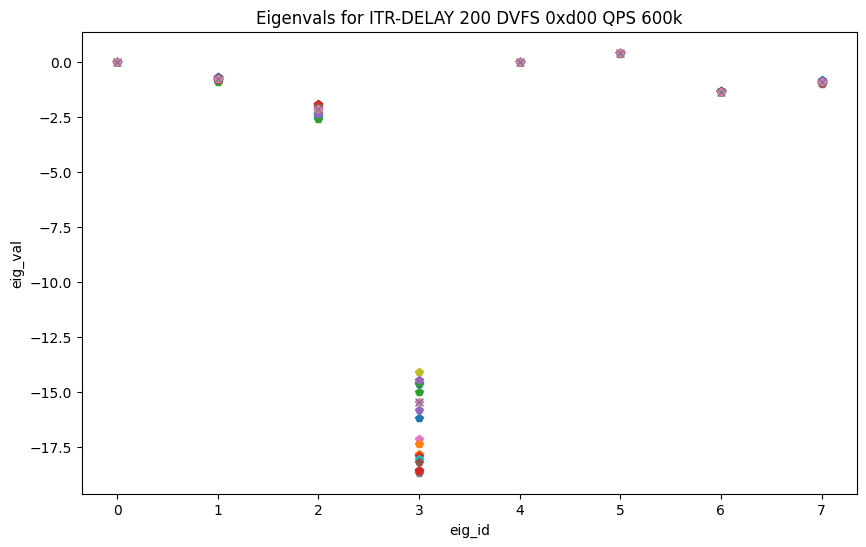

<Figure size 640x480 with 0 Axes>

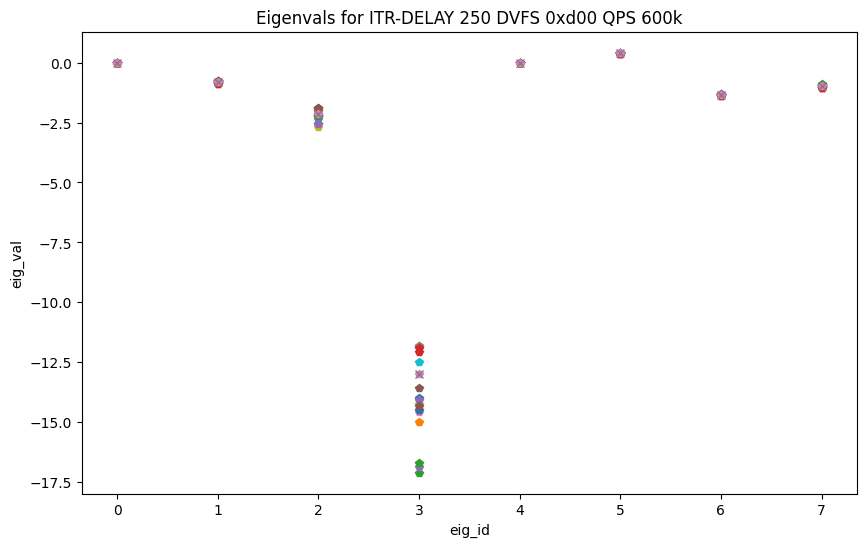

<Figure size 640x480 with 0 Axes>

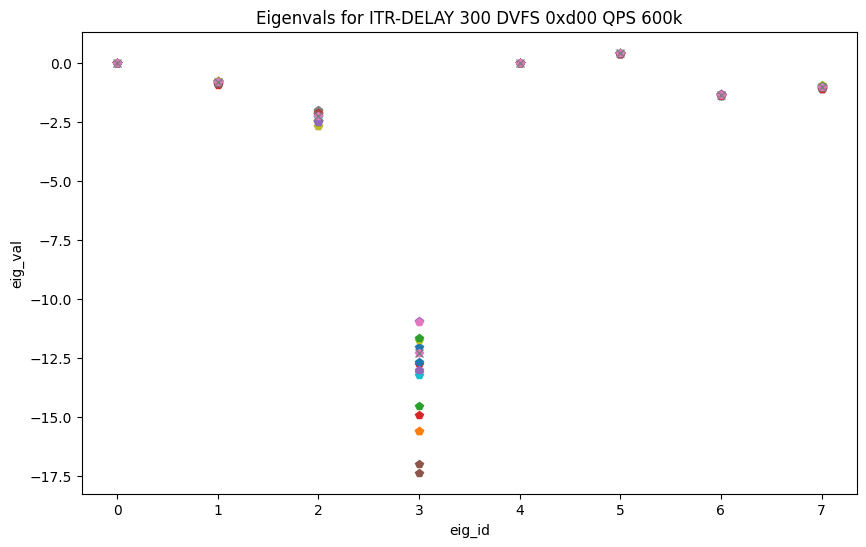

<Figure size 640x480 with 0 Axes>

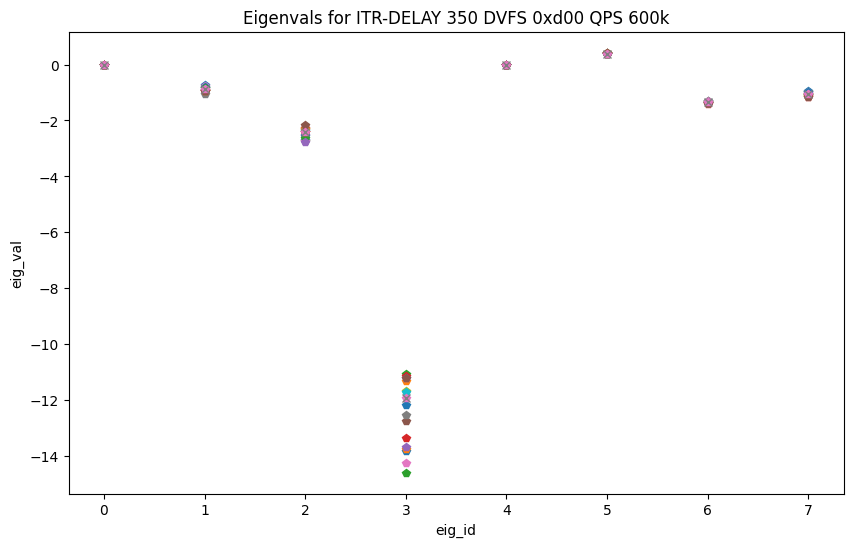

<Figure size 640x480 with 0 Axes>

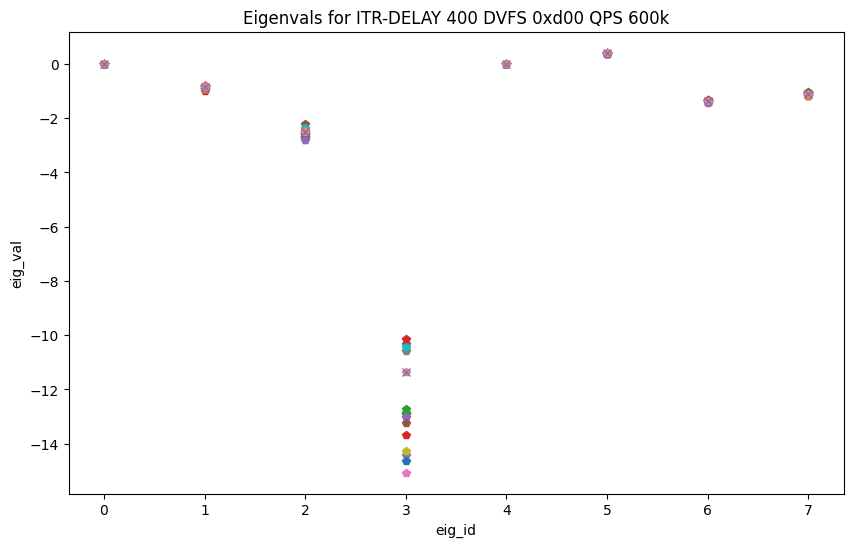

<Figure size 640x480 with 0 Axes>

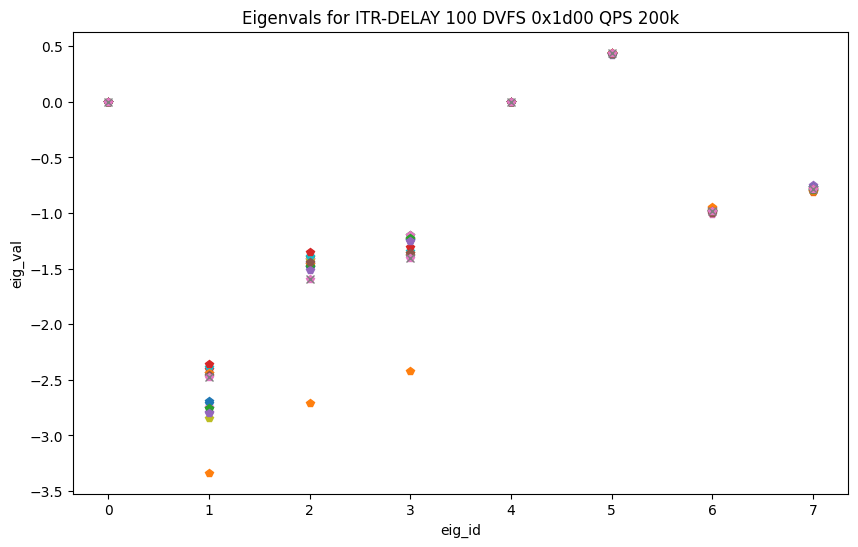

<Figure size 640x480 with 0 Axes>

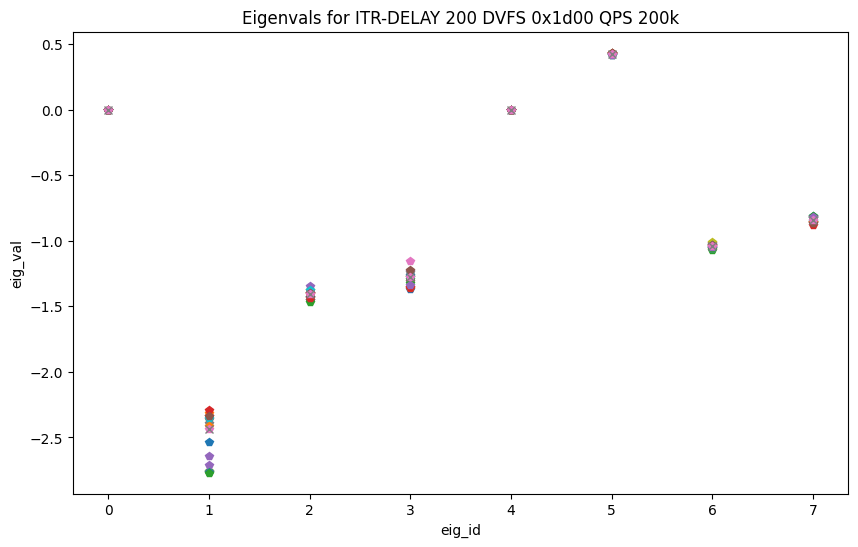

<Figure size 640x480 with 0 Axes>

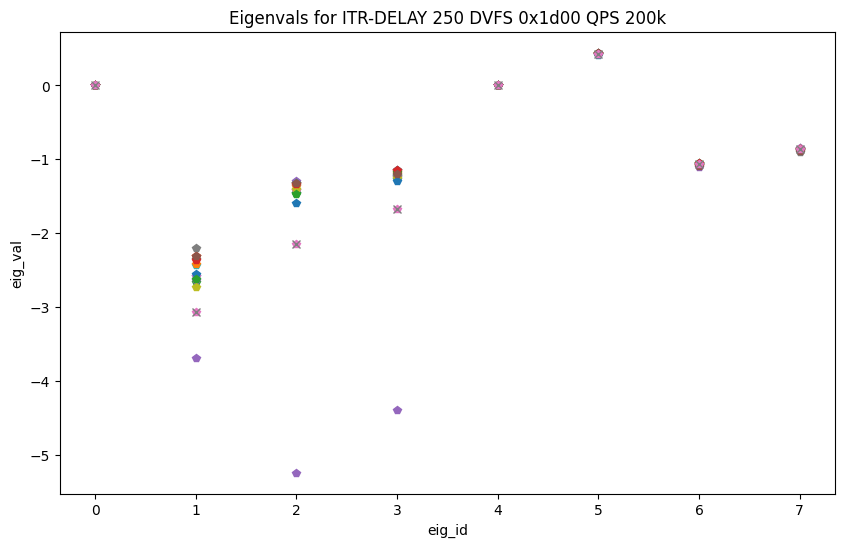

<Figure size 640x480 with 0 Axes>

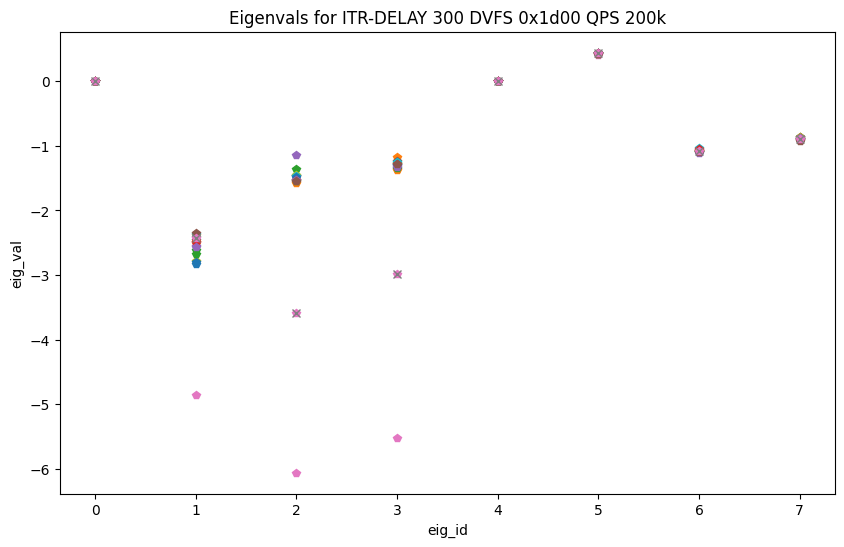

<Figure size 640x480 with 0 Axes>

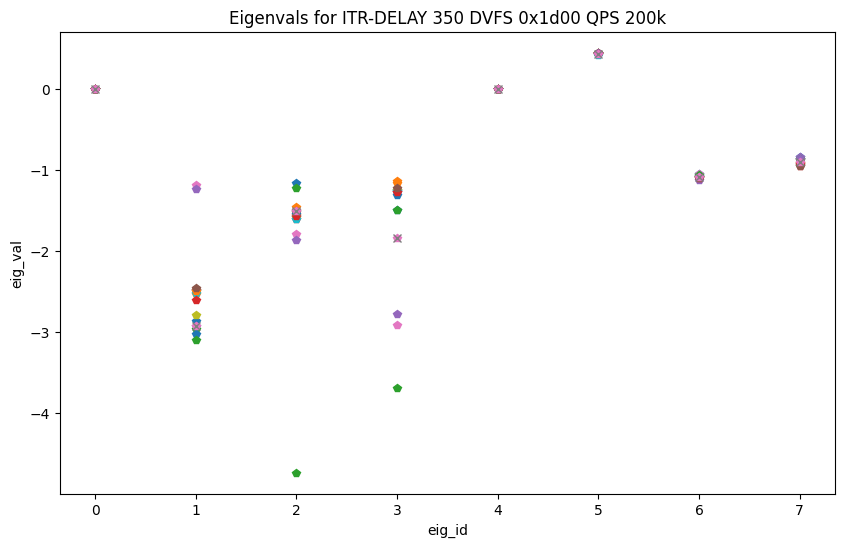

<Figure size 640x480 with 0 Axes>

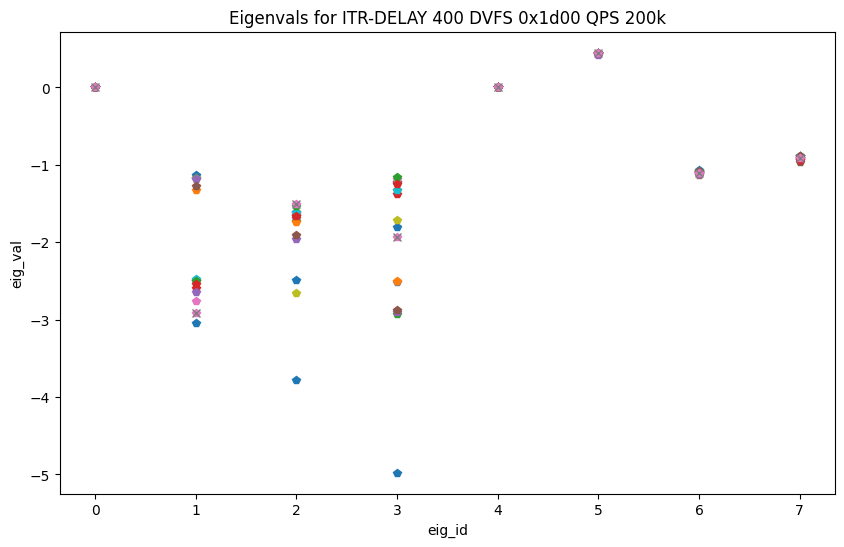

<Figure size 640x480 with 0 Axes>

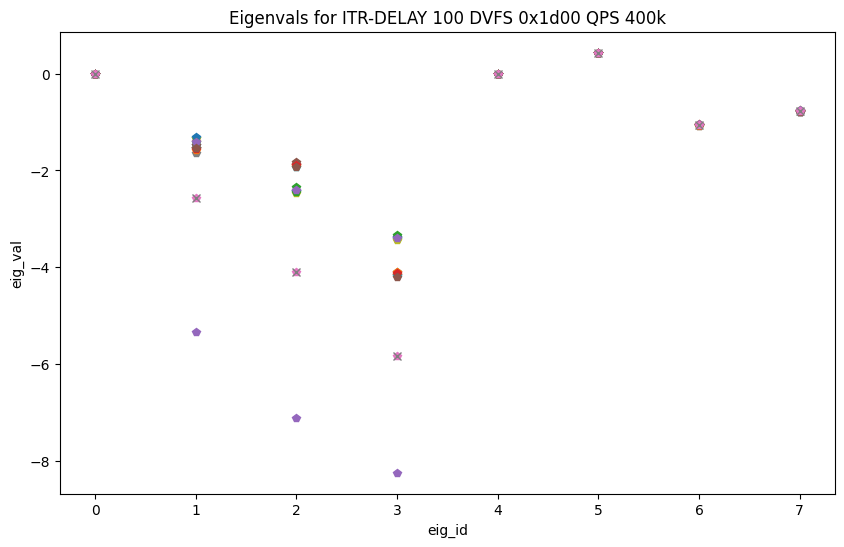

<Figure size 640x480 with 0 Axes>

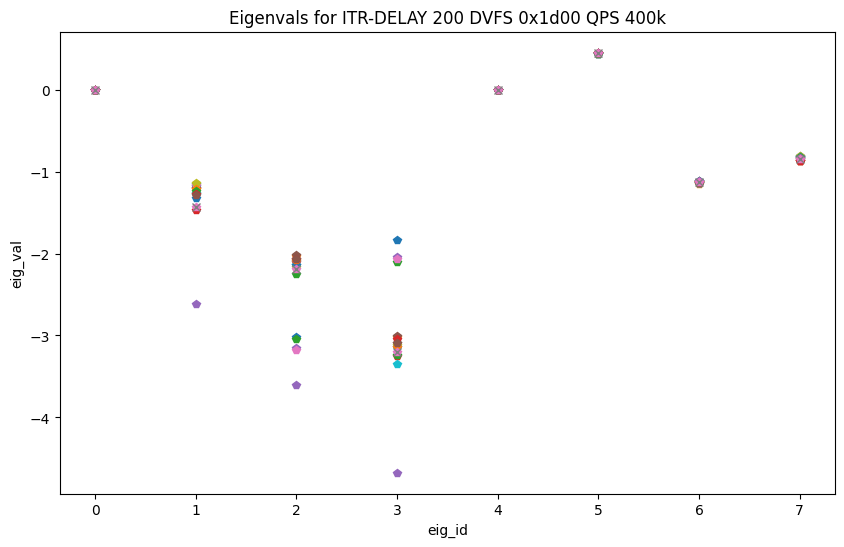

<Figure size 640x480 with 0 Axes>

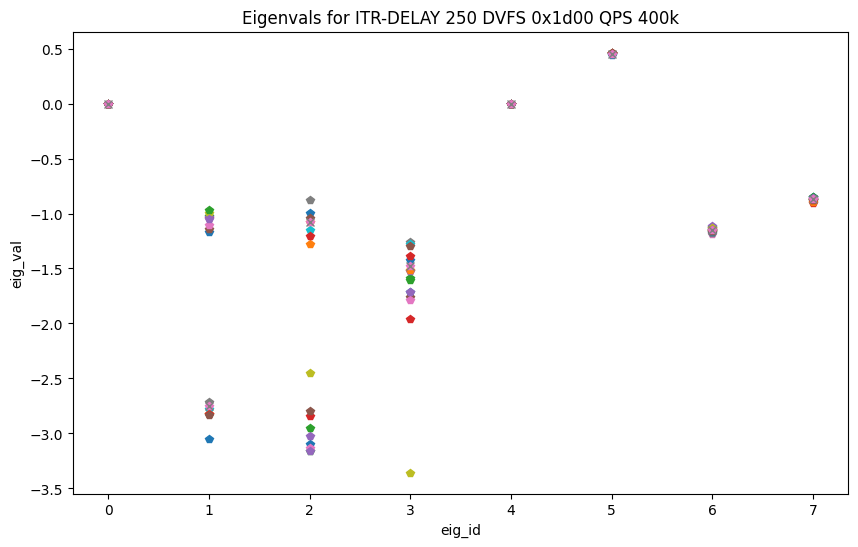

<Figure size 640x480 with 0 Axes>

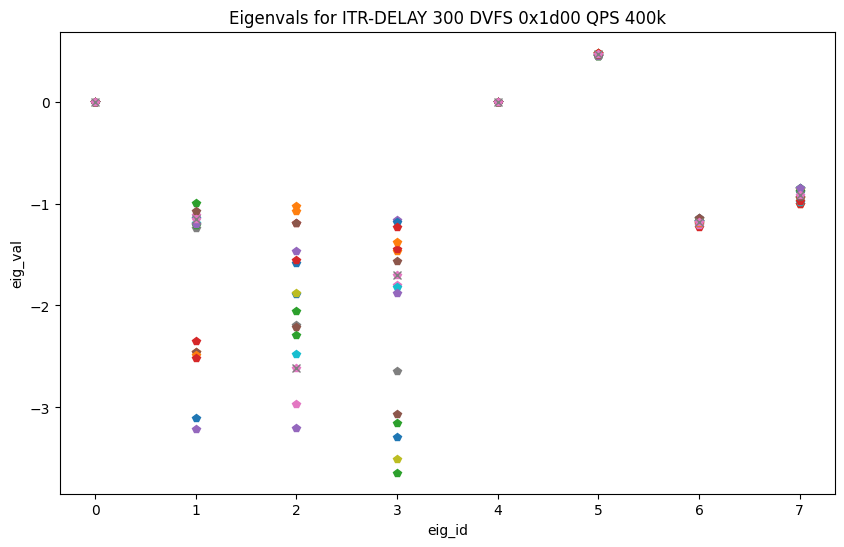

<Figure size 640x480 with 0 Axes>

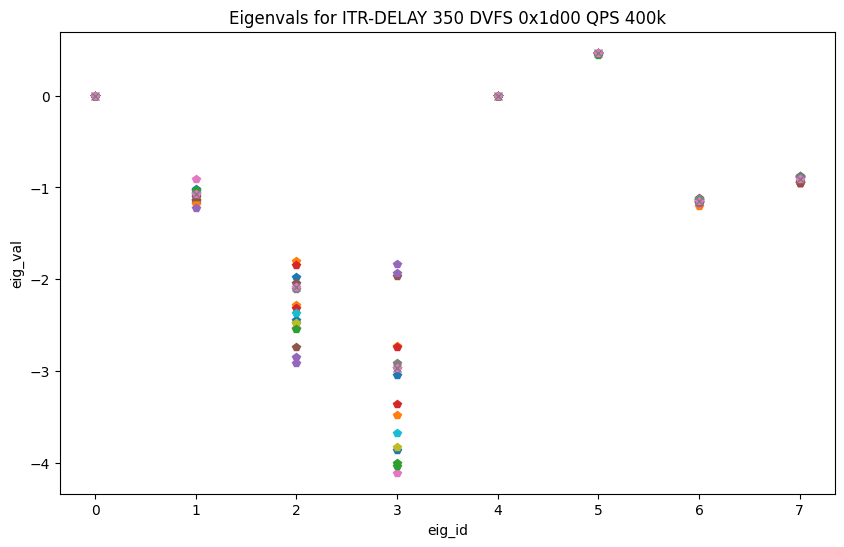

<Figure size 640x480 with 0 Axes>

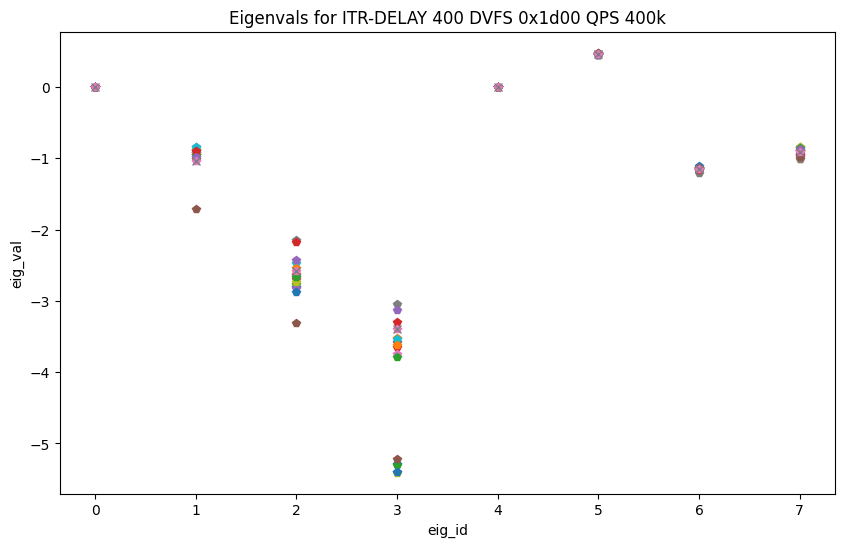

<Figure size 640x480 with 0 Axes>

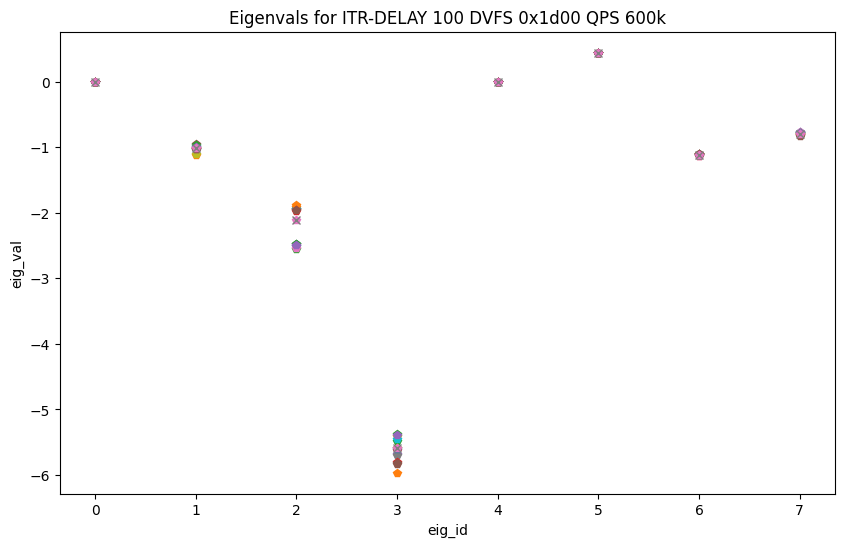

<Figure size 640x480 with 0 Axes>

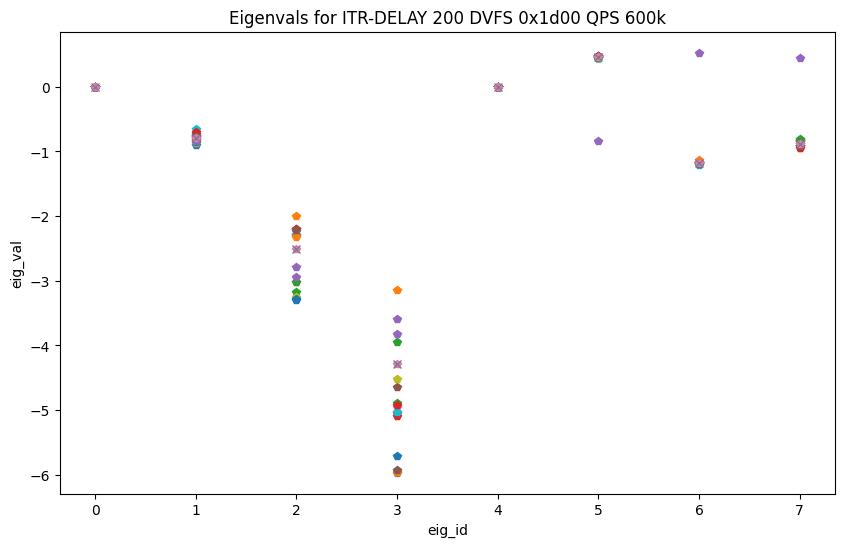

<Figure size 640x480 with 0 Axes>

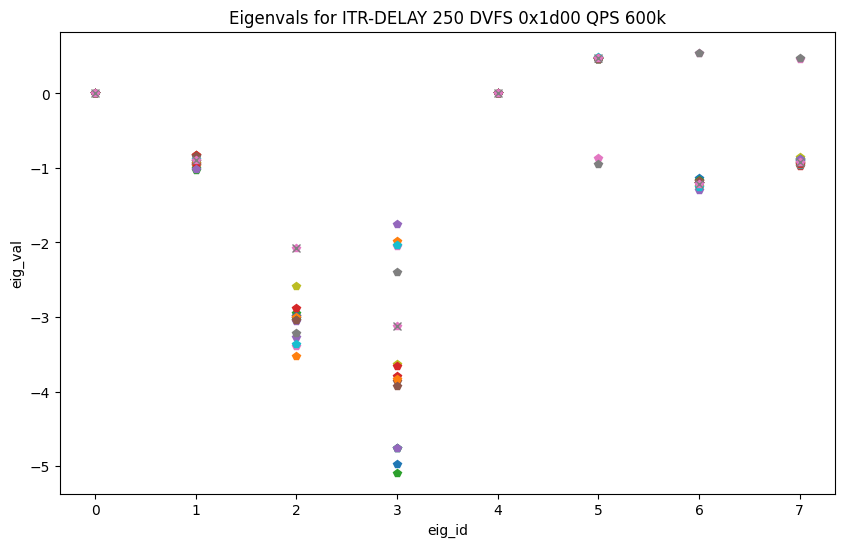

<Figure size 640x480 with 0 Axes>

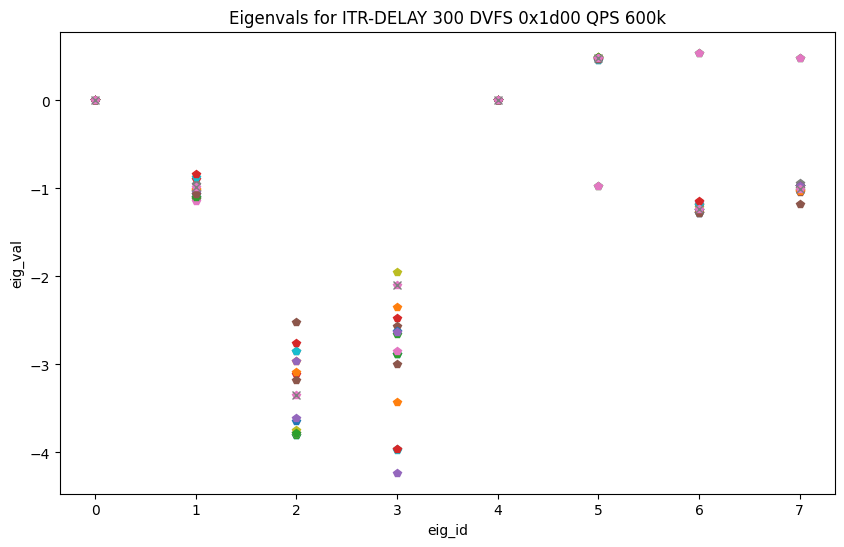

<Figure size 640x480 with 0 Axes>

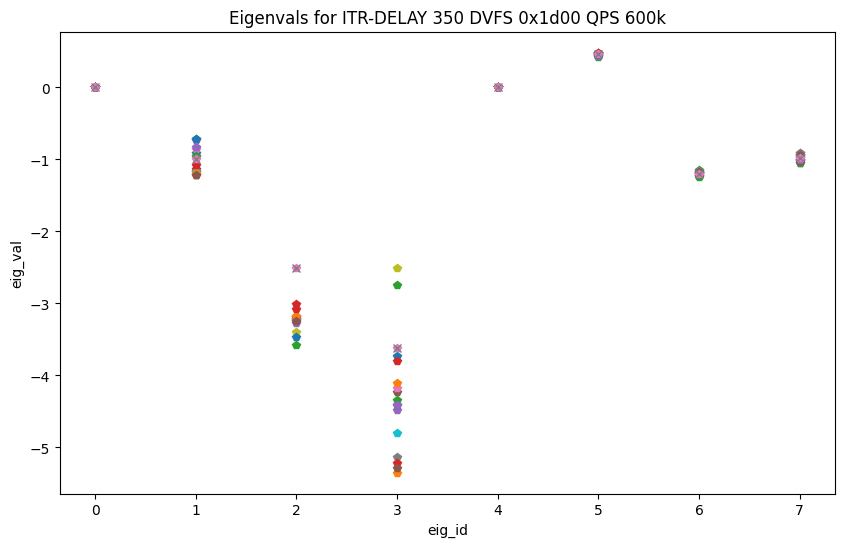

<Figure size 640x480 with 0 Axes>

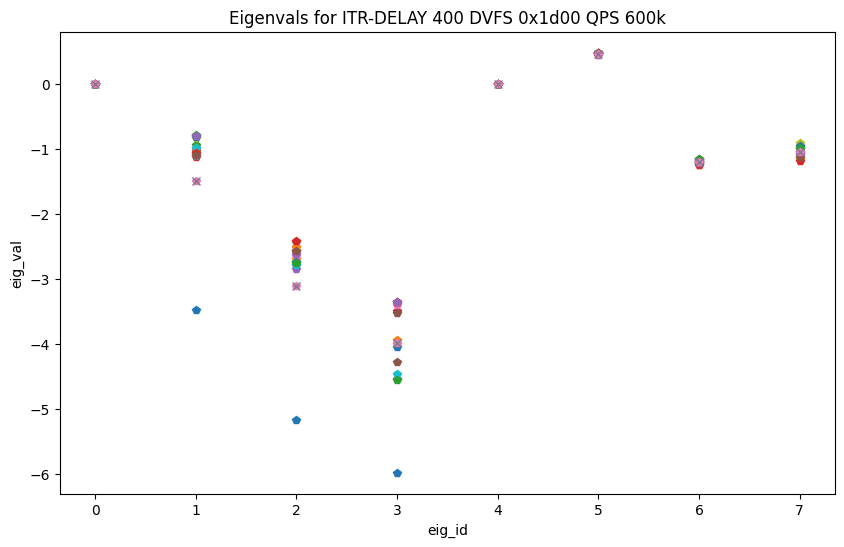

<Figure size 640x480 with 0 Axes>

In [138]:
for dvfs in ['0xd00', '0x1d00']:
#for dvfs in ['0xd00']:
    for qps in ['200k', '400k', '600k']:
    #for qps in ['400k']:
        for itr in ['100', '200', '250','300', '350', '400']:
            counters_corr_dict, non_counters_corr_dict = per_core_corr(dvfs, qps, itr)
            merged_counters_corr, merged_non_counters_corr = merged_core_corr(dvfs, qps, itr)
            eig_vals = get_eig_vals(counters_corr_dict, non_counters_corr_dict, merged_counters_corr, merged_non_counters_corr)
            plot_eig_vals(eig_vals, dvfs, qps, itr)